In [1]:
# Configure logging first - add this at the very top of your script
import logging
logging.basicConfig(level=logging.ERROR)  # Only show ERROR level and above
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
import seaborn as sns
sys.path.append('/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/')
#from src.utils.logger_functions import console
from src.cmos_plotter.Plotter_Helper_KV import *
from src.utils.metadata_functions import load_metadata_as_dataframe
from src.utils.logger_functions import console
from src.cmos_plotter import Conduction_speed_plotter as csp
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
# Silence just the matplotlib.font_manager logger
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

/usr/itetnas04/data-scratch-01/kvulic/data/conda_envs/old_sorter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart'

#RECORDINGS_PATH = os.path.join(MAIN_PATH,f'Raw_Traces')
#RECORDINGS_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/2_Raw_Data/Plasticity_Experiments/Raw_Data/BCM_Test/1821'
SORTER_PATH = os.path.join(MAIN_PATH, f'Sorters_stimulation')
CONDUCTION_SPEEDS_PATH = os.path.join(MAIN_PATH, f'Results/Conduction_speeds_stimulation/')

if not os.path.exists(CONDUCTION_SPEEDS_PATH):
    os.makedirs(CONDUCTION_SPEEDS_PATH)

#metadata = load_metadata_as_dataframe(file_path=MAIN_PATH)


In [4]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Pickle_files_1851'
CONDUCTION_SPEEDS_PATH = os.path.join(MAIN_PATH, f'Results/Conduction_speeds/')
with open(os.path.join(CONDUCTION_SPEEDS_PATH, 'Conduction_speeds_all.pkl'), 'rb') as f:
   df_1 = pickle.load(f)
   

In [5]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart'
CONDUCTION_SPEEDS_PATH = os.path.join(MAIN_PATH, f'Results/Conduction_speeds/')
with open(os.path.join(CONDUCTION_SPEEDS_PATH, 'Conduction_speeds_all.pkl'), 'rb') as f:
   df_2 = pickle.load(f)
   

In [24]:
with open(os.path.join(CONDUCTION_SPEEDS_PATH, 'Conduction_speeds_all.pkl'), 'rb') as f:
   speeds = pickle.load(f)
   


In [15]:
speeds = pd.DataFrame(speeds)
speeds.keys()

Index(['unit', 'direction', 'chip_id', 'div', 'cell_type', 'area', 'filename',
       'speed_ms-1'],
      dtype='object')

In [15]:
import pandas as pd
import pickle
import os

def add_unit_speeds_to_csv(pickle_file_path, csv_file_path, output_csv_path):
    # Load the pickle file with unit speeds
    with open(pickle_file_path, 'rb') as f:
        unit_data = pickle.load(f)
    
    # Convert pickle data to DataFrame for easier processing
    unit_df = pd.DataFrame(unit_data)
    
    # Load the CSV file
    #csv_df = pd.read_csv(csv_file_path)
    csv_df = pd.read_pickle(csv_file_path)
    
    # Create new columns for speeds if they don't exist
    if 'source_speed' not in csv_df.columns:
        csv_df['source_speed'] = None
    if 'target_speed' not in csv_df.columns:
        csv_df['target_speed'] = None
    
    # Track the rows processed and skipped
    rows_processed = 0
    rows_skipped = 0
    
    # Process each row in the CSV
    for idx, row in csv_df.iterrows():
        # Skip rows where both speeds already exist and are not None/NaN
        if pd.notna(row.get('source_speed')) and pd.notna(row.get('target_speed')):
            rows_skipped += 1
            continue
            
        rows_processed += 1
        
        # Extract filename from CSV and convert to match pickle filename format
        csv_filename = row['filename']
        
        # Remove the "_processed_info_metrics" suffix and add back the original extension
        if "_processed_info_metrics" in csv_filename:
            pickle_filename = csv_filename.replace("_processed_info_metrics", "")
            if not pickle_filename.endswith(".pkl") and not pickle_filename.endswith(".h5"):
                pickle_filename += ".h5"  # Add back the original extension if needed
        
        pickle_filename = pickle_filename.replace('.pkl', '.h5')  # Ensure we have .h5 extension
        
        # Get source and target unit IDs
        source_unit_id = row['source_unit_id']
        target_unit_id = row['target_unit_id']
        
        # Find corresponding speeds in the pickle data
        source_speed = None
        target_speed = None
        
        # Find speed for source unit
        source_matches = unit_df[(unit_df['filename'] == pickle_filename) & 
                               (unit_df['unit'] == source_unit_id)]
        if not source_matches.empty:
            source_speed = source_matches.iloc[0]['speed_ms-1']
        
        # Find speed for target unit
        target_matches = unit_df[(unit_df['filename'] == pickle_filename) & 
                               (unit_df['unit'] == target_unit_id)]
        if not target_matches.empty:
            target_speed = target_matches.iloc[0]['speed_ms-1']
        
        # Update the CSV DataFrame
        csv_df.at[idx, 'source_speed'] = source_speed
        csv_df.at[idx, 'target_speed'] = target_speed
    
    # Save the updated CSV
    #csv_df.to_csv(output_csv_path, index=False)
    csv_df.to_pickle(output_csv_path)
    
    # Return statistics
    total_rows = len(csv_df)
    source_speeds_found = csv_df['source_speed'].notna().sum()
    target_speeds_found = csv_df['target_speed'].notna().sum()
    
    return {
        'total_rows': total_rows,
        'rows_processed': rows_processed,
        'rows_skipped': rows_skipped,
        'source_speeds_found': source_speeds_found, 
        'target_speeds_found': target_speeds_found,
        'source_match_rate': f"{source_speeds_found/total_rows*100:.2f}%",
        'target_match_rate': f"{target_speeds_found/total_rows*100:.2f}%"
    }


def add_unit_firing_metrics_to_csv(pickle_file_path, csv_file_path, output_csv_path):
    # Load the pickle file with unit speeds
    with open(pickle_file_path, 'rb') as f:
        unit_data = pickle.load(f)
    
    # Convert pickle data to DataFrame for easier processing
    unit_df = pd.DataFrame(unit_data)
    
    # Load the CSV file
    #csv_df = pd.read_csv(csv_file_path)
    csv_df = pd.read_pickle(csv_file_path)
    
    # Create new columns for speeds if they don't exist
    if 'source_firing_rate' not in csv_df.columns:
        csv_df['source_firing_rate'] = None
    if 'target_firing_rate' not in csv_df.columns:
        csv_df['target_firing_rate'] = None
    if 'source_isi_mean' not in csv_df.columns:
        csv_df['source_isi_mean'] = None
    if 'target_isi_mean' not in csv_df.columns:
        csv_df['target_isi_mean'] = None
    if 'source_isi_median' not in csv_df.columns:
        csv_df['source_isi_median'] = None
    if 'target_isi_median' not in csv_df.columns:
        csv_df['target_isi_median'] = None
    if 'source_isi_std' not in csv_df.columns:
        csv_df['source_isi_std'] = None
    if 'target_isi_std' not in csv_df.columns:
        csv_df['target_isi_std'] = None
    if 'source_isi_cv' not in csv_df.columns:
        csv_df['source_isi_cv'] = None
    if 'target_isi_cv' not in csv_df.columns:
        csv_df['target_isi_cv'] = None
    
    # Track the rows processed and skipped
    rows_processed = 0
    rows_skipped = 0
    
    # Process each row in the CSV
    for idx, row in csv_df.iterrows():
        # Skip rows where both speeds already exist and are not None/NaN
        if pd.notna(row.get('source_firing_rate')) and pd.notna(row.get('target_firing_rate')):
            if pd.notna(row.get('source_isi_mean')) and pd.notna(row.get('target_isi_mean')):
                if pd.notna(row.get('source_isi_median')) and pd.notna(row.get('target_isi_median')):
                    if pd.notna(row.get('source_isi_std')) and pd.notna(row.get('target_isi_std')):
                        if pd.notna(row.get('source_isi_cv')) and pd.notna(row.get('target_isi_cv')):
                            rows_skipped += 1
                            continue
            
        rows_processed += 1
        
        # Extract filename from CSV and convert to match pickle filename format
        csv_filename = row['filename']

        print
        
        # Remove the "_processed_info_metrics" suffix and add back the original extension
        if "_processed_info_metrics" in csv_filename:
            pickle_filename = csv_filename.replace("_processed_info_metrics", "")
            if not pickle_filename.endswith(".pkl") and not pickle_filename.endswith(".h5"):
                pickle_filename += ".h5"  # Add back the original extension if needed
        
            pickle_filename = pickle_filename.replace('.pkl', '.h5')  # Ensure we have .h5 extension
        else:
             pickle_filename = csv_filename
        
        # Get source and target unit IDs
        source_unit_id = row['source_unit_id']
        target_unit_id = row['target_unit_id']
        
        # Find corresponding speeds in the pickle data
        source_firing_rate = None
        target_firing_rate = None
        source_isi_mean = None
        target_isi_mean = None
        source_isi_median = None
        target_isi_median = None
        source_isi_std = None
        target_isi_std = None
        source_isi_cv = None
        target_isi_cv = None

        
        # Find speed for source unit
        source_matches = unit_df[(unit_df['filename'] == pickle_filename) & 
                               (unit_df['unit_id'] == source_unit_id)]
        if not source_matches.empty:
            source_firing_rate = source_matches.iloc[0]['firing_rate']
            source_isi_mean = source_matches.iloc[0]['isi_mean']
            source_isi_median = source_matches.iloc[0]['isi_median']
            source_isi_std = source_matches.iloc[0]['isi_std']
            source_isi_cv = source_matches.iloc[0]['isi_cv']

        
        # Find speed for target unit
        target_matches = unit_df[(unit_df['filename'] == pickle_filename) & 
                               (unit_df['unit_id'] == target_unit_id)]
        if not target_matches.empty:
            target_firing_rate = target_matches.iloc[0]['firing_rate']
            target_isi_mean = target_matches.iloc[0]['isi_mean']
            target_isi_median = target_matches.iloc[0]['isi_median']
            target_isi_std = target_matches.iloc[0]['isi_std']
            target_isi_cv = target_matches.iloc[0]['isi_cv']
            
        
        # Update the CSV DataFrame
        csv_df.at[idx, 'source_firing_rate'] = source_firing_rate
        csv_df.at[idx, 'target_firing_rate'] = target_firing_rate
        csv_df.at[idx, 'source_isi_mean'] = source_isi_mean
        csv_df.at[idx, 'target_isi_mean'] = target_isi_mean
        csv_df.at[idx, 'source_isi_median'] = source_isi_median
        csv_df.at[idx, 'target_isi_median'] = target_isi_median
        csv_df.at[idx, 'source_isi_std'] = source_isi_std
        csv_df.at[idx, 'target_isi_std'] = target_isi_std
        csv_df.at[idx, 'source_isi_cv'] = source_isi_cv
        csv_df.at[idx, 'target_isi_cv'] = target_isi_cv
       
    # Save the updated CSV
    #csv_df.to_csv(output_csv_path, index=False)
    csv_df.to_pickle(output_csv_path)
    
    # Return statistics
    total_rows = len(csv_df)
    source_firing_rates_found = csv_df['source_firing_rate'].notna().sum()
    target_firing_rates_found = csv_df['target_firing_rate'].notna().sum()
    
    return {
        'total_rows': total_rows,
        'rows_processed': rows_processed,
        'rows_skipped': rows_skipped,
        'source_firing_rates_found': source_firing_rates_found,
        'target_firing_rates_found': target_firing_rates_found, 
        'source_match_rate': f"{source_firing_rates_found/total_rows*100:.2f}%",
        'target_match_rate': f"{target_firing_rates_found/total_rows*100:.2f}%"
    }

In [3]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart'


In [20]:
#csv_file_path = os.path.join(MAIN_PATH, 'biTE_stimulation/Full_dataset/CSVs/validated_results_full_data_w_speed_and_firing.csv')
outuput_csv_path = os.path.join(MAIN_PATH, 'biTE_stimulation/Full_dataset/CSVs/validated_results_full_data_w_speed_and_firing.pkl')
#stats = add_unit_speeds_to_csv(os.path.join(CONDUCTION_SPEEDS_PATH, '250429_stimulation/Conduction_speeds_all.pkl'), 
#                              outuput_csv_path, 
#                              outuput_csv_path)
stats_2 = add_unit_firing_metrics_to_csv(os.path.join(MAIN_PATH, 'biTE_stimulation/Full_dataset/Full_firing_files/all_extremum_results.pkl'),
                                outuput_csv_path, 
                                outuput_csv_path)
print(stats_2)

{'total_rows': 26024, 'rows_processed': 26024, 'rows_skipped': 0, 'source_firing_rates_found': 26024, 'target_firing_rates_found': 26024, 'source_match_rate': '100.00%', 'target_match_rate': '100.00%'}


In [21]:
data = pd.read_pickle(os.path.join(MAIN_PATH, 'biTE_stimulation/Full_dataset/CSVs/validated_results_full_data_w_speed_and_firing.pkl'))    


In [22]:
data = data[data['validation'] == 'good']
data

,source_electrode,target_electrode,source_unit_id,target_unit_id,lag,validation,mTE,syn probability,latency_extremum,electrodes_source_unit,...,source_firing_rate,target_firing_rate,source_isi_mean,target_isi_mean,source_isi_median,target_isi_median,source_isi_std,target_isi_std,source_isi_cv,target_isi_cv
9,18095,18095,94,90,1.0,good,0.000288,0.403226,"[[0, 1219.1499999999999, 0.0, input], [1, 2327...","[18972, 18313, 20955, 20075, 19414, 18753, 209...",...,1.727585,5.208787,580.715858,192.1875,512.05,95.975,454.663174,237.749568,0.782936,1.237071
16,22494,21834,69,13,1.0,good,0.001189,0.101064,"[[0, 477.6, 0.0, input], [1, 1160.300000000000...","[20955, 20075, 19414, 20953, 21174, 21616, 189...",...,2.083595,0.284216,481.2196,3588.824,327.05,2897.8,459.519935,2340.361609,0.954907,0.652125
21,18095,18095,90,106,1.0,good,0.001462,0.159405,"[[0, 221.70000000000002, 0.0, input], [1, 222....","[18972, 18313, 20736, 20955, 20075, 19858, 194...",...,5.208787,2.46906,192.1875,405.922584,95.975,313.95,237.749568,396.495177,1.237071,0.976775
22,18095,18095,98,106,1.0,good,0.000690,0.148244,"[[0, 222.55, 0.0, input], [1, 223.0, 0.0, inpu...","[18972, 18313, 20736, 20077, 20075, 19858, 194...",...,4.272915,2.46906,234.336979,405.922584,107.025,313.95,283.659177,396.495177,1.210476,0.976775
23,18095,18095,94,106,1.0,good,0.000245,0.164516,"[[0, 1219.1499999999999, 0.0, input], [1, 2327...","[18972, 18313, 20955, 20075, 19414, 18753, 209...",...,1.727585,2.46906,580.715858,405.922584,512.05,313.95,454.663174,396.495177,0.782936,0.976775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26282,4755,9593,90,63,2.0,good,0.000845,0.201581,"[[0, 67.8, 0.0, input], [0, 70.35, 2.55, outpu...","[8933, 4318, 4756, 11573, 4316, 4096, 8494, 49...",...,1.525527,2.848737,658.1125,351.770273,136.0,209.9,1221.174627,522.662658,1.855571,1.485807
26285,12465,5215,12,84,6.0,good,0.002543,0.477157,"[[0, 1138.9499999999998, 0.0, input], [0, 1145...","[11804, 9825, 12023, 2566, 6966, 6086, 8066, 5...",...,1.181557,5.350648,850.658929,187.101842,446.325,83.525,1441.275667,263.743289,1.694305,1.409624
26288,14226,4098,10,78,4.0,good,0.002763,0.260664,"[[0, 158.65, 0.0, input], [1, 417.85, 0.0, inp...","[14226, 21050, 13785, 20392, 19293, 19954, 155...",...,2.513267,0.712735,398.83361,1414.936441,375.15,1029.325,227.705571,1149.667554,0.570929,0.812522
26290,1908,1908,88,7,2.0,good,0.001545,0.115974,"[[0, 180.35000000000002, 0.0, input], [1, 310....","[11147, 4547, 7627, 2566, 9168, 6528, 8508, 16...",...,2.727022,0.541735,367.504496,1866.660674,299.775,1069.65,554.903899,2872.812364,1.509924,1.539012


In [23]:
#data = data[data['filename'] != 'ID2184_7_DIV32_DATE20250415_1136_spontaneous_Freq_variation.raw_processed_info_metrics.pkl']
#data = data[data['filename'] != 'ID2816_0_DIV41_DATE20250424_1525_spontaneous_FreqVarDel0V2_20Hz.raw_processed_info_metrics..pkl']
data.to_pickle(os.path.join(MAIN_PATH, 'biTE_stimulation/Full_dataset/CSVs/validated_results_full_data_w_speed_and_firing.pkl'))


In [40]:
plt.figure(figsize=(12, 6))

speeds = speeds[speeds['div'] > 10]
#speeds = speeds[speeds['div'].isin([23, 65, 107, 129, 147])]

# Calculate SEM for each DIV group
sem = speeds.groupby('div')['speed_ms-1'].sem().reset_index(name='sem')
means = speeds.groupby('div')['speed_ms-1'].mean().reset_index(name='mean_speed')

# Merge the dataframes
plot_data = pd.merge(means, sem, on='div')

# Plot with error bars showing SEM
plt.errorbar(x=plot_data['div'], y=plot_data['mean_speed'], 
             yerr=plot_data['sem'], 
             fmt='o-', capsize=5, elinewidth=1.5, markersize=8, color = 'dimgray')

#plt.title('Conduction speed vs Div')
plt.xlabel('Day In Vitro', fontsize = 18)
plt.ylabel('Conduction speed (m/s)', fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.3, 0.8)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(CONDUCTION_SPEEDS_PATH, 'Conduction_speed_vs_Div.png'), dpi=300)
plt.savefig(os.path.join(CONDUCTION_SPEEDS_PATH, 'Conduction_speed_vs_Div.pdf'), dpi=300, format ='pdf')

plt.show()
#plt.figure(figsize=(10, 6))

NameError: name 'plt' is not defined

In [56]:
def custom_lineplot(data, x_metric, y_metric, axes, label, fontsize=16, labelsize=14, xlim = None, ylim = None, save_path=None):
    plt.rcParams['xtick.bottom'] = True    
    plt.rcParams['ytick.left'] = True    
    plt.rcParams['font.family'] = 'Arial'    
    sns.lineplot(data=data, x=x_metric, y=y_metric, color="dimgrey", markers=True, estimator="mean", 
                 err_style="bars", legend=True, zorder=1, ax=axes, dashes=False, marker="o", ms=10, linewidth=0.5, errorbar=("ci", 95))        
    axes.set_ylabel(label, fontsize=fontsize)    
    axes.set_xlabel("Day In Vitro", fontsize=fontsize)    
    axes.grid(True, linestyle=':', alpha=0.7)    
    axes.tick_params(axis='both', which='major', labelsize=labelsize, width=1.5, length=8)
    if xlim is not None:
        axes.set_xlim(xlim)
    if ylim is not None:
        axes.set_ylim(ylim)
    if save_path:
        plt.savefig(os.path.join(save_path, f'{label[:-3]}.png'), dpi=300)
        plt.savefig(os.path.join(save_path, f'{label[:-3]}.pdf'), dpi=300)
    

TypeError: list indices must be integers or slices, not str

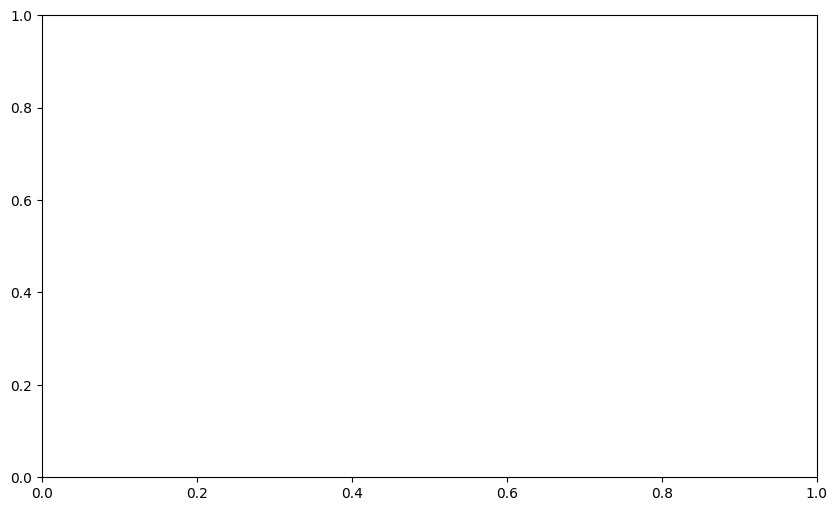

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
speeds = speeds[speeds['div'] > 10]
custom_lineplot(speeds, speeds['div'], speeds['speed_ms-1'], ax, label = 'Conduction Speed [m/s]', fontsize=16, labelsize=14, xlim = None, ylim = (0.35,0.7), save_path = CONDUCTION_SPEEDS_PATH)      

In [7]:
def multi_dataframe_lineplot(data_list, x_metrics, y_metrics, axes, labels, colors, fontsize=16, labelsize=14, xlim=None, ylim=None, save_path=None, log_scale=False):
    plt.rcParams['xtick.bottom'] = True    
    plt.rcParams['ytick.left'] = True    
    plt.rcParams['font.family'] = 'Arial'
    
    # Plot each dataframe with its own color
    for data, x_metric, y_metric, label, color in zip(data_list, x_metrics, y_metrics, labels, colors):
        sns.lineplot(data=data, x=x_metric, y=y_metric, color=color, markers=True, estimator="mean", 
                    err_style="bars", label=label, zorder=1, ax=axes, dashes=False, 
                    marker="o", ms=10, linewidth=0.5, errorbar=("ci", 95))
    
    # Set common axes properties
    axes.set_ylabel(labels[0], fontsize=fontsize)  # Using the first label for y-axis title
    axes.set_xlabel("Log (Day In Vitro)", fontsize=fontsize)    
    axes.grid(True, linestyle=':', alpha=0.7)    
    axes.tick_params(axis='both', which='major', labelsize=labelsize, width=1.5, length=8)
    axes.legend()
    
    if log_scale:
        axes.set_xscale('log')  # Set x-axis to log scale
    

    if xlim is not None:
        axes.set_xlim(xlim)
    if ylim is not None:
        axes.set_ylim(ylim)
    
    if save_path:
        plt.savefig(os.path.join(save_path, f'conduction_speeds_combined.png'), dpi=300)
        plt.savefig(os.path.join(save_path, f'conduction_speeds_combined.pdf'), dpi=300)

In [80]:
CONDUCTION_SPEEDS_PATH

'/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/Results/Conduction_speeds/'

(1171, 8) (5682, 8)


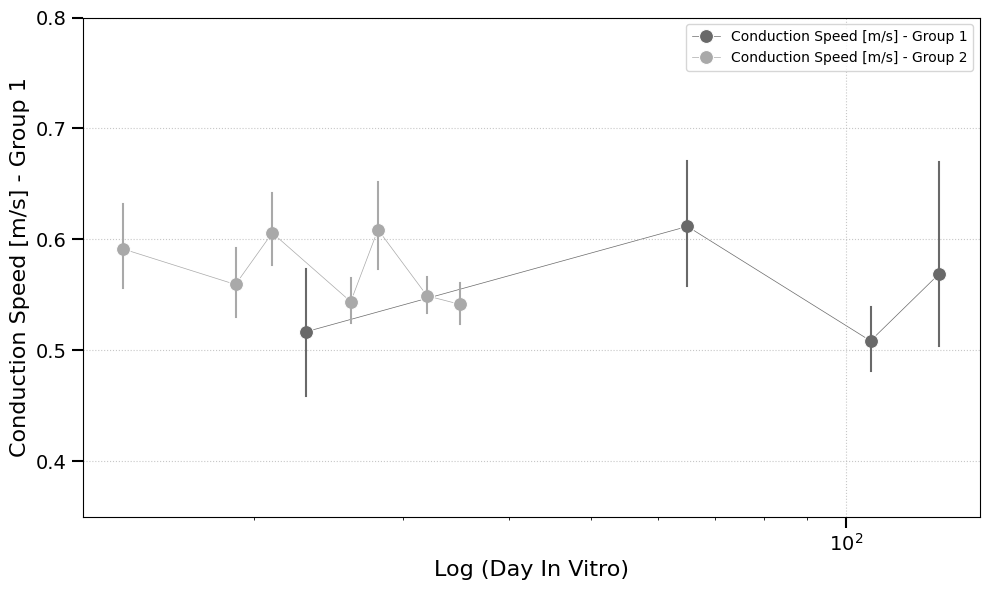

In [8]:
# Filter data if needed (like in your example with speeds)
df_1 = pd.DataFrame(df_1)
df_2 = pd.DataFrame(df_2)
df_2 = df_2[df_2['div'] > 10]
df_1 = df_1[df_1['div'].isin([23, 65, 107, 129, 147])]
print(df_1.shape, df_2.shape)

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors - dimgray for first and a lighter gray for second
colors = ['dimgray', '#A9A9A9']  # dimgray and darkgray

# Call the modified function with both dataframes
multi_dataframe_lineplot(
    data_list=[df_1, df_2],
    x_metrics=[df_1['div'], df_2['div']],
    y_metrics=[df_1['speed_ms-1'], df_2['speed_ms-1']],
    axes=ax,
    labels=['Conduction Speed [m/s] - Group 1', 'Conduction Speed [m/s] - Group 2'],
    colors=colors,
    fontsize=16, 
    labelsize=14, 
    xlim=None, 
    ylim=(0.35, 0.8), 
    save_path=CONDUCTION_SPEEDS_PATH,
    log_scale=True
)

plt.tight_layout()
plt.show()

In [ ]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Pickle_files_1851'

#RECORDINGS_PATH = os.path.join(MAIN_PATH,f'Raw_Traces')
RECORDINGS_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/2_Raw_Data/Plasticity_Experiments/Raw_Data/BCM_Test/1821'
SORTER_PATH = os.path.join(MAIN_PATH, f'Sorters_old_version')
CONDUCTION_SPEEDS_PATH = os.path.join(MAIN_PATH, f'Results/Conduction_speeds')

if not os.path.exists(CONDUCTION_SPEEDS_PATH):
    os.makedirs(CONDUCTION_SPEEDS_PATH)

metadata = load_metadata_as_dataframe(file_path=MAIN_PATH)


2025-03-27 19:04:20,861 Metadata successfully loaded. 
 First 5 rows: 
                                             Filename  DIV  Chip_ID  Network_ID
0  ID1821_3_DIV45_DATE20240405_1455_spontaneous_b...   45     1821           3
1  ID1821_2_DIV45_DATE20240405_1054_spontaneous_b...   45     1821           2
2  ID1821_1_DIV45_DATE20240405_0849_spontaneous_a...   45     1821           1
3  ID1821_3_DIV45_DATE20240405_1508_spontaneous_a...   45     1821           3
4  ID1821_2_DIV45_DATE20240405_1206_spontaneous_a...   45     1821           2


In [6]:
# Example usage:
df = csp.create_summary_visualization(CONDUCTION_SPEEDS_PATH, CONDUCTION_SPEEDS_PATH, group_by='div')



2025-03-27 19:31:47,731 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-27 19:31:47,734 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-27 19:31:47,833 Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
2025-03-27 19:31:47,840 Embedding font /usr/share/fonts/truetype/msttcorefonts/Arial.ttf.
2025-03-27 19:31:47,841 Writing TrueType font.
2025-03-27 19:31:48,088 Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
2025-03-27 19:31:48,125 Embedding font /usr/share/fonts/truetype/msttcorefonts/Arial.ttf.
2025-03-27 19:31:48,125 Writing TrueType font.


In [10]:
with open('/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Ferrans_processed_data_heart/Results/Conduction_speeds/metadata_ID1652_N0_DIV28_DATE20230306_spontaneous.raw.h5.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
data

dict_keys(['sampling_rate', 'probe_locations', 'templates'])